In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [16]:
# Set style for visualizations
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)
# Load the data
csv_path = "../../data/raw/SPLV_raw.csv"
df = pd.read_csv(csv_path, parse_dates=["Date"])

In [17]:
# General Data Overview
print("\nInformación del DataFrame:")
print(df.info())

print("\nValores faltantes por columna:")
print(df.isnull().sum())


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 0 to 1076
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1077 non-null   datetime64[ns]
 1   Close   1077 non-null   float64       
 2   High    1077 non-null   float64       
 3   Low     1077 non-null   float64       
 4   Open    1077 non-null   float64       
 5   Volume  1077 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 50.6 KB
None

Valores faltantes por columna:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [18]:
df.head(10)

,Date,Close,High,Low,Open,Volume
0,2020-12-24,51.149937,51.149937,50.902081,50.929620,1175900
1,2020-12-28,51.278446,51.434501,51.140748,51.351883,1891700
2,2020-12-29,51.232548,51.535480,51.076489,51.406963,1967200
3,2020-12-30,51.149937,51.388610,51.094857,51.260093,1297900
4,2020-12-31,51.618095,51.673176,51.012228,51.122385,2295200
5,2021-01-04,51.021420,51.719084,50.562429,51.682364,5100200
6,2021-01-05,51.177464,51.296802,50.690935,50.938790,2723700
7,2021-01-06,51.608917,51.792511,50.911249,50.947969,8988600
8,2021-01-07,51.801701,52.003658,51.498765,51.654824,2435800
9,2021-01-08,52.003670,52.031208,51.544679,51.820073,2888800


In [19]:
print("\nEstadísticas descriptivas:")
print(df.drop(columns=["Date"]).describe())


Estadísticas descriptivas:
             Close         High          Low         Open        Volume
count  1077.000000  1077.000000  1077.000000  1077.000000  1.077000e+03
mean     61.319811    61.618225    60.995444    61.308589  2.977137e+06
std       5.318353     5.333005     5.301509     5.319372  2.349494e+06
min      49.636395    50.538543    49.360228    50.041443  5.056000e+05
25%      58.326679    58.642497    58.059646    58.340463  1.618800e+06
50%      60.417011    60.687342    60.012381    60.366618  2.261500e+06
75%      63.324799    63.652915    63.021961    63.302924  3.400900e+06
max      74.950890    75.320351    74.481572    74.960879  2.333230e+07


Aquí vemos que el precio de SPLV se mueve en un rango bastante estable, entre unos $50 y $75, con una media cerca de $61. Las diferencias entre apertura, cierre, máximo y mínimo son pequeñas, lo que nos confirma que es un ETF súper tranquilo. Lo interesante está en el volumen: en promedio es de casi 3 millones, pero puede llegar hasta los 23 millones, así que claramente hay días donde se mueve muchísimo más de lo normal.uestra que los precios (Open, High, Low, Close) tienen promedios muy similares (~61 USD) y desviaciones estándar bajas (~5), lo cual confirma que SPLV es un ETF de baja volatilidad. El volumen es más variable, con valores entre 0.5 y 23 millones, lo cual sugiere que los cambios en la actividad del mercado podrían tener impacto en ciertos momentos específicos.

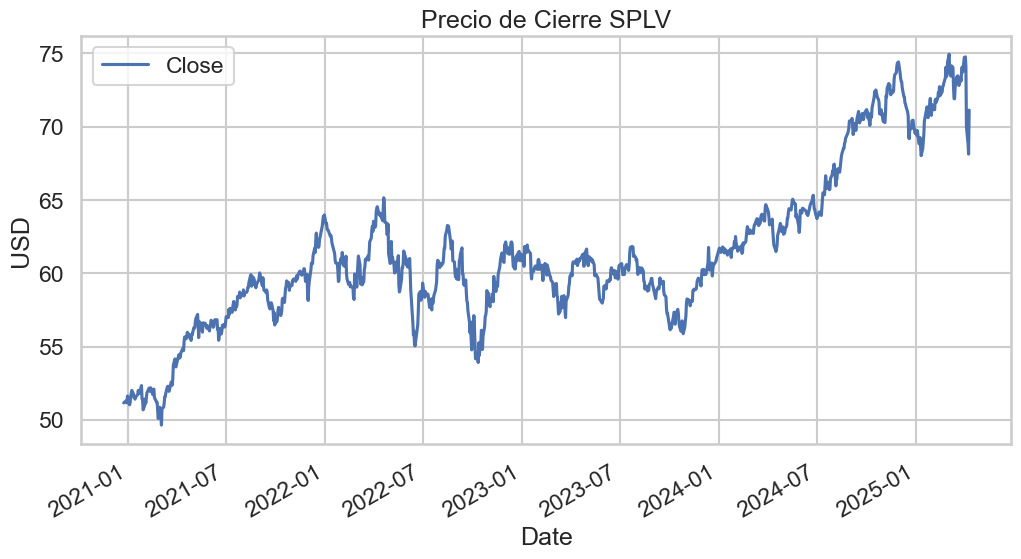

In [20]:
# Add daily returns
df["Return"] = df["Close"].pct_change()

# Plot Closing Price
df.plot(x="Date", y="Close", title="Precio de Cierre SPLV", ylabel="USD")
plt.show()

El precio ha ido subiendo de forma constante desde 2021, aunque con algunas pausas y bajones. No hay caídas fuertes ni subidas locas, todo muy alineado con lo que uno espera de un ETF de baja volatilidad. Parece que SPLV es más de ir paso a paso, sin hacer olas.


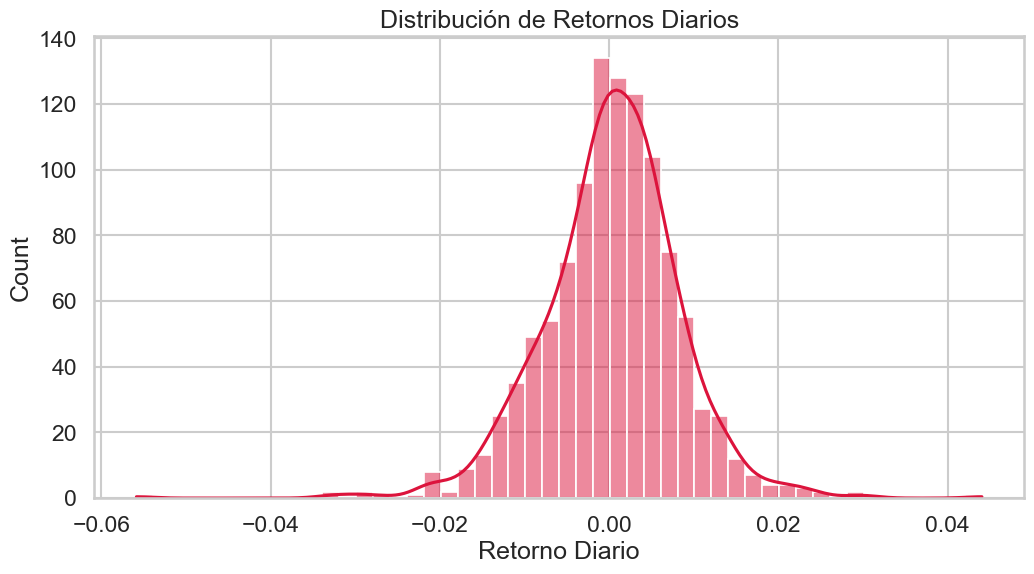

In [21]:
# Plot Return distribution
sns.histplot(df["Return"].dropna(), bins=50, kde=True, color="crimson")
plt.title("Distribución de Retornos Diarios")
plt.xlabel("Retorno Diario")
plt.show()

Esta campana nos dice que la mayoría de los días SPLV apenas se mueve, y cuando lo hace, casi siempre es un poquito arriba o un poquito abajo. Casi no hay días extremos, ni súper positivos ni súper negativos. Muy tranquilo, muy estable. Ideal si se quiere predecir movimientos pequeños con un modelo que no dependa de sobresaltos.

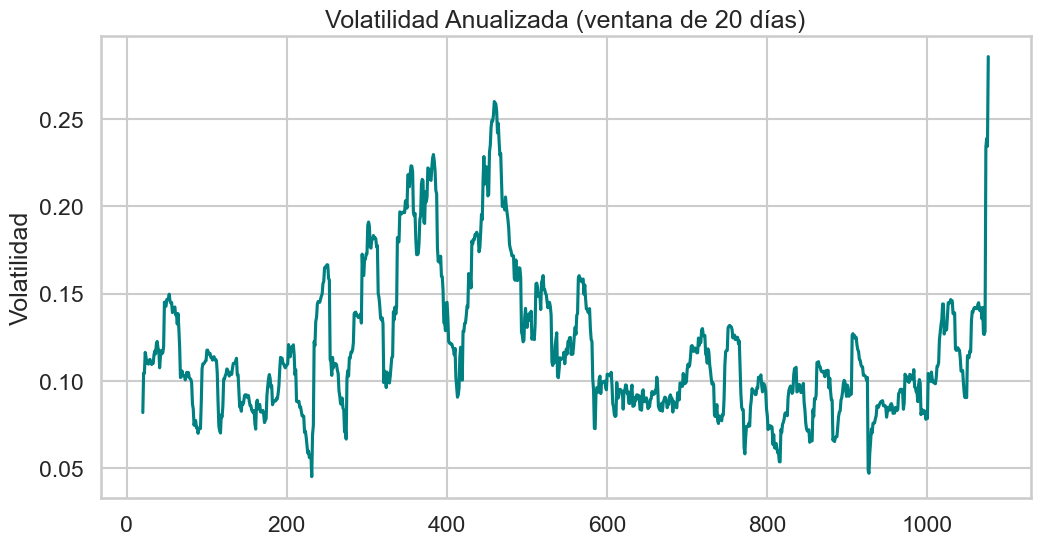

In [22]:
# Volatilidad móvil anualizada
df["Volatility20"] = df["Return"].rolling(20).std() * np.sqrt(252)
df["Volatility20"].plot(color="teal")
plt.title("Volatilidad Anualizada (ventana de 20 días)")
plt.ylabel("Volatilidad")
plt.show()

Aunque SPLV es calmado, hay momentos donde su volatilidad sube un poco, sobre todo en ciertos picos. Esto no es muy común, pero cuando pasa puede significar que algo raro o importante está pasando en el mercado. Quizá esos momentos valga la pena marcarlos como zonas “fuera de lo normal”.


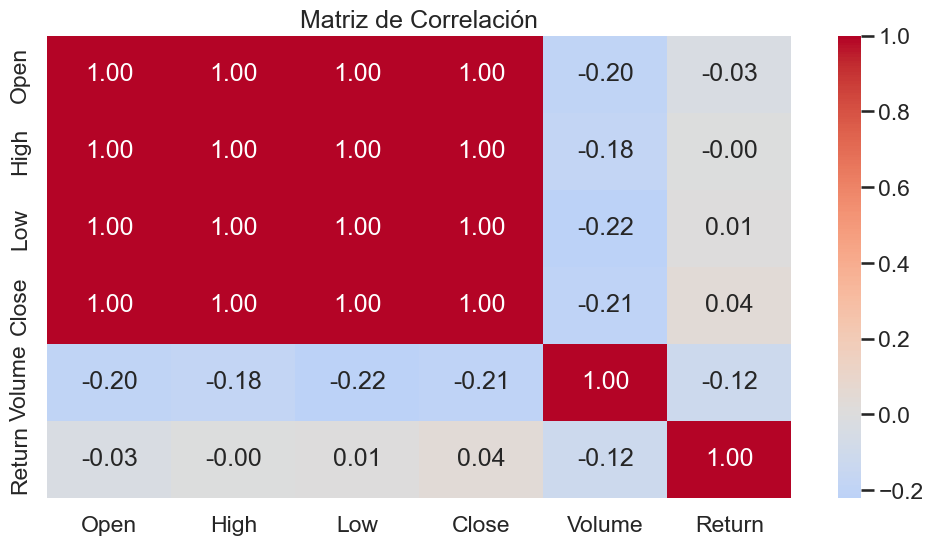

In [23]:
# Correlación entre variables relevantes
corr = df[["Open", "High", "Low", "Close", "Volume", "Return"]].dropna().corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de Correlación")
plt.show()

Todo lo relacionado con precios está muy correlacionado, como era de esperarse. Así que no hace falta usar todas esas columnas, con Close basta para derivar el resto. El volumen y los retornos no tienen mucha relación directa con el precio. 


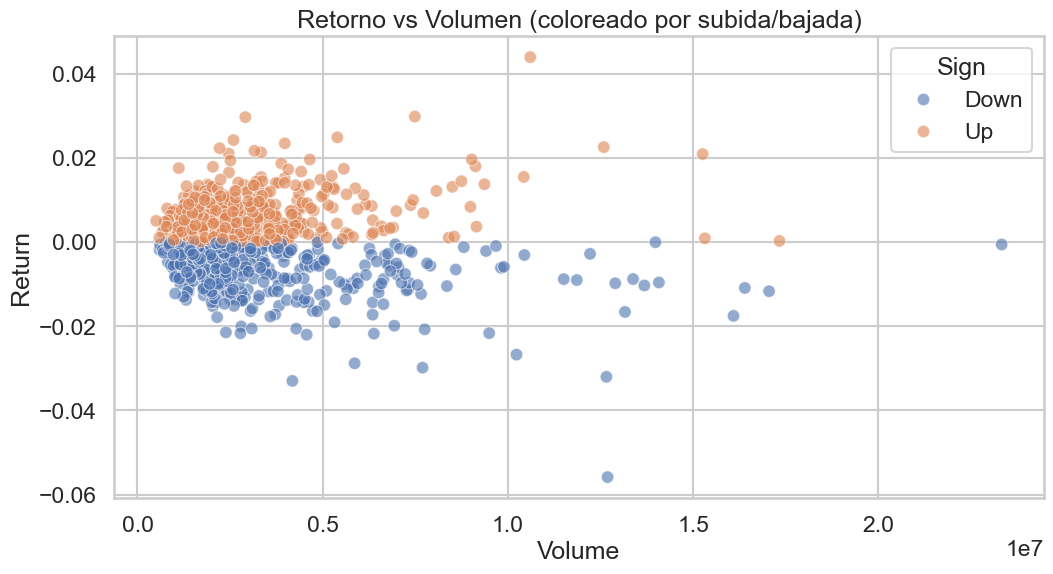

In [24]:
# Scatter plot: Return vs. Volume (Up vs Down)
df["Sign"] = np.where(df["Return"] > 0, "Up", "Down")
sns.scatterplot(x="Volume", y="Return", hue="Sign", data=df, alpha=0.6)
plt.title("Retorno vs Volumen (coloreado por subida/bajada)")
plt.show()

El gráfico muestra cuando SPLV sube o baja, el volumen no cambia mucho la historia. No hay una regla clara de que más volumen sea buena o mala señal. Pero sí vemos que cuando hay bajadas fuertes, a veces hay más volumen, como si la gente estuviera vendiendo de golpe.

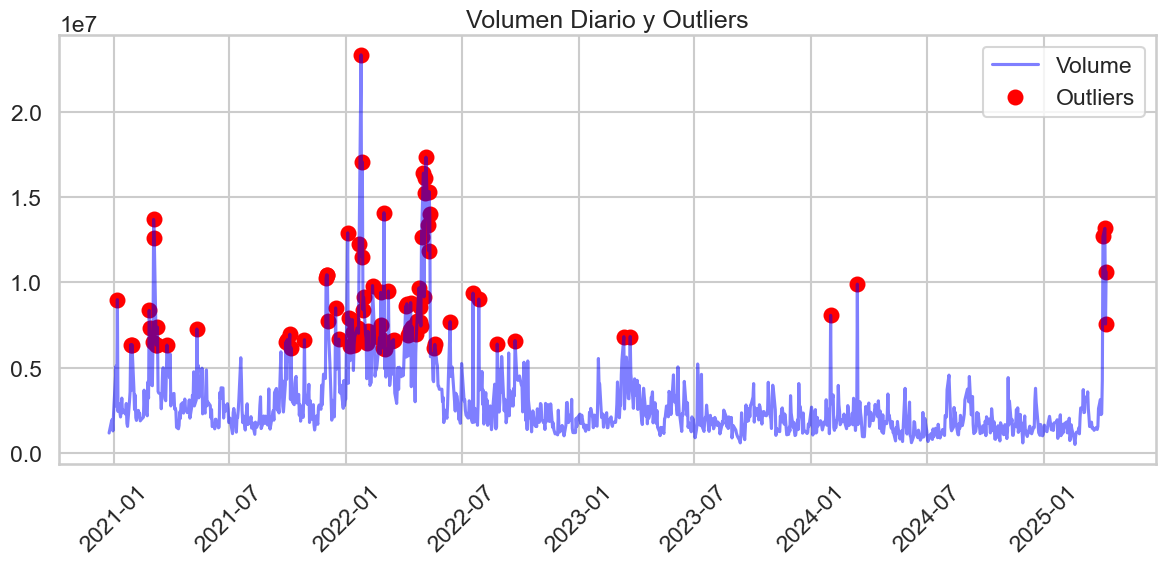

In [25]:
# Outlier detection solo para volumen
Q1 = df["Volume"].quantile(0.25)
Q3 = df["Volume"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_volume = df[(df["Volume"] < lower_bound) | (df["Volume"] > upper_bound)]

# Visualizar outliers
plt.plot(df["Date"], df["Volume"], label="Volume", color="blue", alpha=0.5)
if not outliers_volume.empty:
    plt.scatter(outliers_volume["Date"], outliers_volume["Volume"], color="red", label="Outliers", s=100)
plt.title("Volumen Diario y Outliers")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Aquí se ven claramente los días donde el volumen se disparó. Pasa en momentos puntuales, sobre todo entre 2021 y 2022. Estos picos podrían ser momentos de rebalanceo, noticias o simplemente movimientos grandes del mercado. Los outliers no se borran ni modifican. 